In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Business Problem:
To create a **Recommender System** to show **personalized movie recommendations** based on ratings given **by a user and other users similar** to them in order **to improve user experience.**

### Importing required packages:

In [ ]:
import pandas as pd
import numpy as np
import math as math
import keras
import seaborn as sns
sns.set(style='whitegrid')
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (15, 6)

# Exploratory Data Analysis:

In [ ]:
#fixed-width formatted (fwf)
movies = pd.read_fwf('/content/drive/MyDrive/Scaler_Data/ZEE_recomm/zee-movies.dat',encoding='latin-1')
ratings = pd.read_fwf('/content/drive/MyDrive/Scaler_Data/ZEE_recomm/zee-ratings.dat',encoding = 'ISO-8859-1')
users = pd.read_fwf('/content/drive/MyDrive/Scaler_Data/ZEE_recomm/zee-users.dat',encoding = 'ISO-8859-1')

## Movies (EDA):

In [ ]:
movies.head()

,Movie ID::Title::Genres,Unnamed: 1,Unnamed: 2
0,1::Toy Story (1995)::Animation|Children's|Comedy,NaN,NaN
1,2::Jumanji (1995)::Adventure|Children's|Fantasy,NaN,NaN
2,3::Grumpier Old Men (1995)::Comedy|Romance,NaN,NaN
3,4::Waiting to Exhale (1995)::Comedy|Drama,NaN,NaN
4,5::Father of the Bride Part II (1995)::Comedy,NaN,NaN


In [ ]:
# Feature Engineering

movies.drop(columns=['Unnamed: 1','Unnamed: 2'],inplace=True)
delimeter = "::"
movies = movies['Movie ID::Title::Genres'].str.split(delimeter,expand=True)
movies.columns = ['MovieID','Title','Genres']

In [ ]:
movies.head()


,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:

movies.describe()

,MovieID,Title,Genres
count,3883,3883,3858
unique,3883,3883,360
top,1,Toy Story (1995),Drama
freq,1,1,830


In [ ]:
movies.shape

(3883, 3)

In [ ]:
 movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   MovieID  3883 non-null   object
 1   Title    3883 non-null   object
 2   Genres   3858 non-null   object
dtypes: object(3)
memory usage: 91.1+ KB


## Ratings (EDA)

In [ ]:
ratings.head()

,UserID::MovieID::Rating::Timestamp
0,1::1193::5::978300760
1,1::661::3::978302109
2,1::914::3::978301968
3,1::3408::4::978300275
4,1::2355::5::978824291


In [ ]:
delimeter = "::"
ratings = ratings['UserID::MovieID::Rating::Timestamp'].str.split(delimeter,expand=True)
ratings.columns = ['UserID','MovieID','Rating','Timestamp']

In [ ]:
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [ ]:
ratings.shape

(1000209, 4)

In [ ]:
ratings.describe()

,UserID,MovieID,Rating,Timestamp
count,1000209,1000209,1000209,1000209
unique,6040,3706,5,458455
top,4169,2858,4,975528402
freq,2314,3428,348971,30


## Users (EDA):

In [ ]:
users.head()

,UserID::Gender::Age::Occupation::Zip-code
0,1::F::1::10::48067
1,2::M::56::16::70072
2,3::M::25::15::55117
3,4::M::45::7::02460
4,5::M::25::20::55455


In [ ]:
delimeter = "::"
users = users['UserID::Gender::Age::Occupation::Zip-code'].str.split(delimeter,expand=True)
users.columns = ['UserID','Gender','Age','Occupation','Zip-code']

In [ ]:
users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [ ]:
users.shape

(6040, 5)

In [ ]:
users.describe()

,UserID,Gender,Age,Occupation,Zip-code
count,6040,6040,6040,6040,6040
unique,6040,2,7,21,3439
top,1,M,25,4,48104
freq,1,4331,2096,759,19


## Merging Datasets(movies, ratings and users)

In [ ]:
df = pd.merge(pd.merge(movies,ratings,left_on = 'MovieID',right_on='MovieID',how='inner'),users,on='UserID',how='inner')

In [ ]:
df.head()

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268,F,1,10,48067
1,48,Pocahontas (1995),Animation|Children's|Musical|Romance,1,5,978824351,F,1,10,48067
2,150,Apollo 13 (1995),Drama,1,5,978301777,F,1,10,48067
3,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantas,1,4,978300760,F,1,10,48067
4,527,Schindler's List (1993),Drama|War,1,5,978824195,F,1,10,48067


In [ ]:
df.shape

(1000209, 10)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 0 to 1000208
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   MovieID     1000209 non-null  object
 1   Title       1000209 non-null  object
 2   Genres      996144 non-null   object
 3   UserID      1000209 non-null  object
 4   Rating      1000209 non-null  object
 5   Timestamp   1000209 non-null  object
 6   Gender      1000209 non-null  object
 7   Age         1000209 non-null  object
 8   Occupation  1000209 non-null  object
 9   Zip-code    1000209 non-null  object
dtypes: object(10)
memory usage: 83.9+ MB


## Feature Engineering:

In [ ]:
df['Age'] = df['Age'].astype('int32')
df['Rating'] = df['Rating'].astype('int32')
df['Timestamp'] = pd.to_datetime(df['Timestamp'],unit='s')

In [ ]:
df['ReleaseYear'] = df['Title'].str.rsplit(" ",1).str[1].str.lstrip("(").str.rstrip(")")

In [ ]:
df.replace({'Age':{1: "Under 18",
                   18: "18-24",
                   25: "25-34",
                   35: "35-44",
                   45: "45-49",
                   50: "50-55",
                   56: "56+"}},inplace=True)

In [ ]:
df.replace({'Occupation':{'0': "other" or not specified,
                          '1': "academic/educator",
                          '2': "artist",
                          '3': "clerical/admin",
                          '4': "college/grad student",
                          '5': "customer service",
                          '6': "doctor/health care",
                          '7': "executive/managerial",
                          '8': "farmer",
                          '9': "homemaker",
                          '10': "K-12 student",
                          '11': "lawyer",
                          '12': "programmer",
                          '13': "retired",
                          '14': "sales/marketing",
                          '15': "scientist",
                          '16': "self-employed",
                          '17': "technician/engineer",
                          '18': "tradesman/craftsman",
                          '19': "unemployed",
                          '20': "writer"

}},inplace=True)

In [ ]:
df.head()

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,ReleaseYear
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,2001-01-06 23:37:48,F,Under 18,K-12 student,48067,1995
1,48,Pocahontas (1995),Animation|Children's|Musical|Romance,1,5,2001-01-06 23:39:11,F,Under 18,K-12 student,48067,1995
2,150,Apollo 13 (1995),Drama,1,5,2000-12-31 22:29:37,F,Under 18,K-12 student,48067,1995
3,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantas,1,4,2000-12-31 22:12:40,F,Under 18,K-12 student,48067,1977
4,527,Schindler's List (1993),Drama|War,1,5,2001-01-06 23:36:35,F,Under 18,K-12 student,48067,1993


In [ ]:
df['ReleaseYear'].unique()

array(['1995', '1977', '1993', '1992', '1937', '1991', '1996', '1964',
       '1939', '1958', '1950', '1941', '1965', '1982', '1975', '1987',
       '1962', '1989', '1985', '1959', '1997', '1998', '1988', '1942',
       '1947', '1999', '1980', '1983', '1986', '1990', '2000', '1964):',
       '1994', '1978', '1961', '1984', '1972', '1976', '1981', '1973',
       '1974', '1940', 'Bo', '1952', '1954', '1953', '1944', '1968',
       '1957', '1946', '1949', '1951', '1963', '1971', '1979', '1967',
       '1966', '1948', '1933', '1970', '1969', '1930', '1955', '1956', '',
       '1920', '1925', '1938', '195', '1960', '1935', '1932', '1931',
       '1945', '1943', '1981):', '1934', '1936', '1929', 'the', '1926',
       'Arta', 'B', '1927', '19', '1922', 'Polar', '1919', '1921', "d'A",
       '1923', '1989):', '1928', '1995):', 'prendront', '1'], dtype=object)

In [ ]:
df['ReleaseYear'].nunique()

96

In [ ]:
df['ReleaseYear'].replace(['1981):','1964):','1989):','1995):'],['1981','1964','1989','1995'],inplace=True)

In [ ]:
idx_val = df[(df['ReleaseYear'] == 'prendront') | 
   (df['ReleaseYear'] == 'Polar')|
   (df['ReleaseYear'] == 'Bo')|
   (df['ReleaseYear'] == 'Arta')|
   (df['ReleaseYear'] == 'B')|
   (df['ReleaseYear'] == "d'A")|
   (df['ReleaseYear'] == '19')|
   (df['ReleaseYear'] == '')|
   (df['ReleaseYear'] == 'the')|
   (df['ReleaseYear'] == '195')].index
df.drop(index=idx_val,inplace=True)

In [ ]:
df['Title'] = df['Title'].str.rsplit(' ',1).str[0]

In [ ]:
df.head()

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,ReleaseYear
0,1,Toy Story,Animation|Children's|Comedy,1,5,2001-01-06 23:37:48,F,Under 18,K-12 student,48067,1995
1,48,Pocahontas,Animation|Children's|Musical|Romance,1,5,2001-01-06 23:39:11,F,Under 18,K-12 student,48067,1995
2,150,Apollo 13,Drama,1,5,2000-12-31 22:29:37,F,Under 18,K-12 student,48067,1995
3,260,Star Wars: Episode IV - A New Hope,Action|Adventure|Fantas,1,4,2000-12-31 22:12:40,F,Under 18,K-12 student,48067,1977
4,527,Schindler's List,Drama|War,1,5,2001-01-06 23:36:35,F,Under 18,K-12 student,48067,1993


## EDA w.r.t Gender

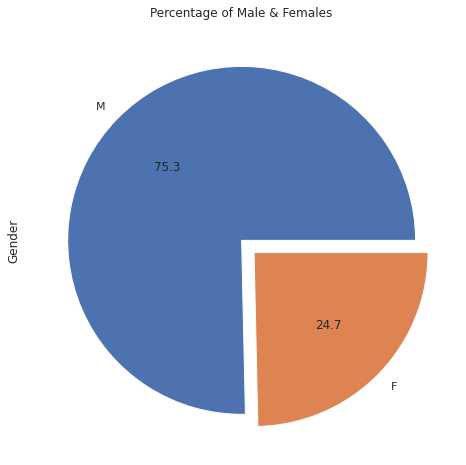

In [ ]:
df['Gender'].value_counts().plot(kind='pie',figsize=(8,8),autopct='%1.1f',explode=[0,0.1])
plt.title('Percentage of Male & Females')
plt.show()

## EDA w.r.t Age:

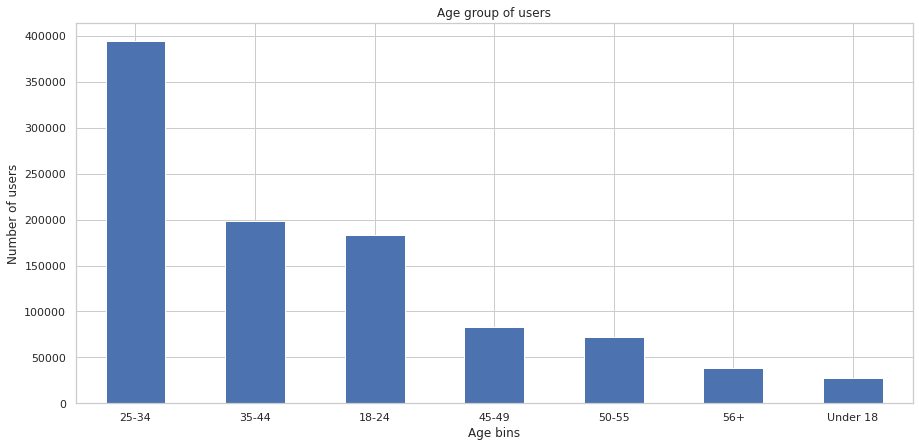

In [ ]:
df['Age'].value_counts().plot(kind='bar',figsize=(15,7))
plt.title('Age group of users')
plt.xlabel('Age bins')
plt.xticks(rotation = 360)
plt.ylabel('Number of users')
plt.show()

## EDA w.r.t Occupation:

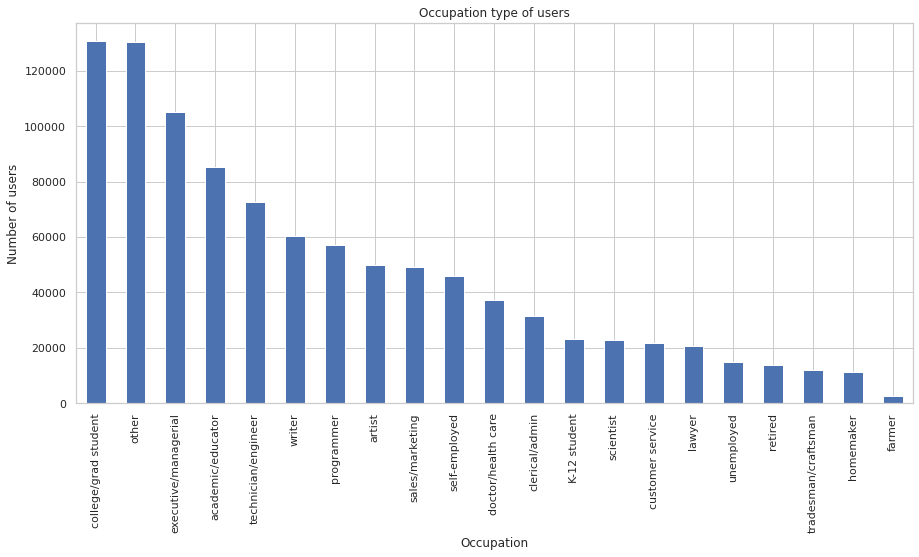

In [ ]:
df['Occupation'].value_counts().plot(kind='bar',figsize=(15,7))
plt.title('Occupation type of users')
plt.xlabel('Occupation')
# plt.xticks(rotation = 45)
plt.ylabel('Number of users')
plt.show()

## EDA w.r.t Ratings:

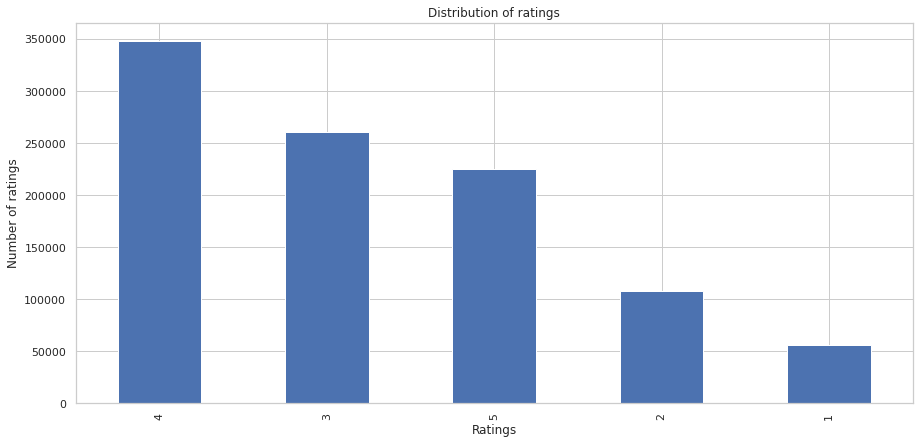

In [ ]:
df['Rating'].value_counts().plot(kind='bar',figsize=(15,7))
plt.title("Distribution of ratings")
plt.xlabel('Ratings')
plt.ylabel('Number of ratings')
plt.show()

## Missing and duplicate values:

In [ ]:
def missing_values(df):
    total_null = df.isnull().sum().sort_values(ascending  = False)
    percent_null = ((df.isnull().sum()/df.shape[0])*100).sort_values(ascending = False)
    print(f"Total records in our data =  {df.shape[0]} where missing values are as follows:")
    missing_data = pd.concat([total_null, percent_null.round(2)], axis = 1,keys=['Total Missing','In Percent'])
    return missing_data

In [ ]:
missing_values(df)

Total records in our data =  997640 where missing values are as follows:


,Total Missing,In Percent
Genres,1496,0.15
MovieID,0,0.00
Title,0,0.00
UserID,0,0.00
Rating,0,0.00
Timestamp,0,0.00
Gender,0,0.00
Age,0,0.00
Occupation,0,0.00
Zip-code,0,0.00


In [ ]:
duplicates = df[df.duplicated()]
print('The number of duplicates rows:', duplicates.shape[0])

The number of duplicates rows: 0


## Data Aggregation:

In [ ]:
# Grouping the data in terms of Average Rating and No. of Ratings given

df.groupby('Title')['Rating'].mean().sort_values(ascending=False).to_frame().reset_index().rename(columns={'Rating':'Average Rating'})

,Title,Average Rating
0,Follow the Bitch,5.0
1,Bittersweet Motel,5.0
2,Schlafes Bruder (Brother of Sleep),5.0
3,Smashing Time,5.0
4,Lured,5.0
...,...,...
3646,Santa with Muscles,1.0
3647,"McCullochs, The",1.0
3648,Torso (Corpi Presentano Tracce di Violenza Car...,1.0
3649,"Fantastic Night, The (La Nuit Fantastique)",1.0


In [ ]:
df.groupby('Title')['Rating'].count().sort_values(ascending=False).to_frame().reset_index().rename(columns={'Rating':'Count'})

,Title,Count
0,American Beauty,3428
1,Star Wars: Episode IV - A New Hope,2991
2,Star Wars: Episode V - The Empire Strikes Back,2990
3,Star Wars: Episode VI - Return of the Jedi,2883
4,Jurassic Park,2672
...,...,...
3646,Slappy and the Stinkers,1
3647,Bye-Bye,1
3648,"Silence of the Palace, The (Saimt el Qusur)",1
3649,Broken Vessels,1


In [ ]:
df_2 = pd.merge(df.groupby('Title')['Rating'].mean().sort_values(ascending=False).to_frame().reset_index().rename(columns={'Rating':'Average Rating'}),df.groupby('Title')['Rating'].count().sort_values(ascending=False).to_frame().reset_index().rename(columns={'Rating':'Count'}),on='Title')
df_2.head()

,Title,Average Rating,Count
0,Follow the Bitch,5.0,1
1,Bittersweet Motel,5.0,1
2,Schlafes Bruder (Brother of Sleep),5.0,1
3,Smashing Time,5.0,2
4,Lured,5.0,1


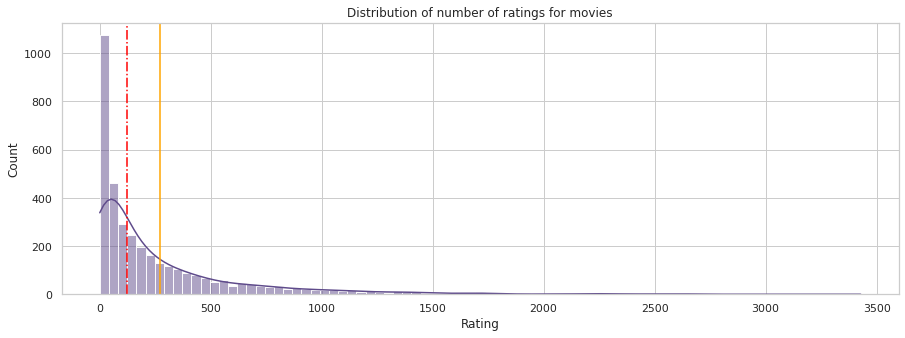

In [ ]:
import seaborn as sns
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
sns.histplot(df.groupby('Title')['Rating'].count(),kde=True,ax=ax,color='#5F4B8B')
ax.axvline(df.groupby('Title')['Rating'].count().mean(), color='orange', linestyle='-',linewidth=1.5)
ax.axvline(df.groupby('Title')['Rating'].count().median(), color='red', linestyle='-.',linewidth=1.5)
ax.set_title("Distribution of number of ratings for movies")
plt.show()

In [ ]:
df.groupby('Title')['Rating'].count().median(), df.groupby('Title')['Rating'].count().mean().round(2)

(125.0, 273.25)

On an average, every movie receives 273 ratings and the median count for ratings is 125. Hence we shall filter all movies which have received less than 125 ratings to find the top rated movies

## Top 5 Rating-wise movies:

In [ ]:
df_2[df_2['Count'] > 125].sort_values(by=['Average Rating'],ascending=False).head(5)

,Title,Average Rating,Count
14,"Shawshank Redemption, The",4.554558,2227
15,"Godfather, The",4.524966,2223
16,"Close Shave, A",4.520548,657
17,"Usual Suspects, The",4.517106,1783
18,Schindler's List,4.510417,2304


# Building a Recommender System based on **Pearson Correlation**

### Creating a pivot table of movie titles & user id and imputing the NaN values

In [ ]:
# pivot table

tab = pd.pivot_table(df,index='UserID',columns='Title',values='Rating',aggfunc='mean')
tab.head()

Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin (Kjærlighetens kjøtere),Zeus and Roxanne,eXistenZ
UserID,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,5.0


We can clearly see that there are a lot of NaN values, we should fill it with 0. We have a sparse matrix

In [ ]:
tab.fillna(0,inplace=True)

In [ ]:
tab.shape

(6040, 3651)

## Item based approach

Here we shall take a movie name as input from the user and return 5 other movies which are similar to the user's choice. To calculate the similarity, I am using pearson correlation.

In [ ]:


mov = input("Enter a movie name : ")
mov_rating = tab[mov]

Enter a movie name : Shawshank Redemption, The


In [ ]:
similar_movies = tab.corrwith(mov_rating)

In [ ]:
#Pearson Correlation

similar_movies.sort_values(ascending=False).to_frame().rename(columns={0:"Correlation"}).head()

,Correlation
Title,
"Shawshank Redemption, The",1.000000
"Silence of the Lambs, The",0.482168
Good Will Hunting,0.480739
Pulp Fiction,0.474547
Schindler's List,0.456980


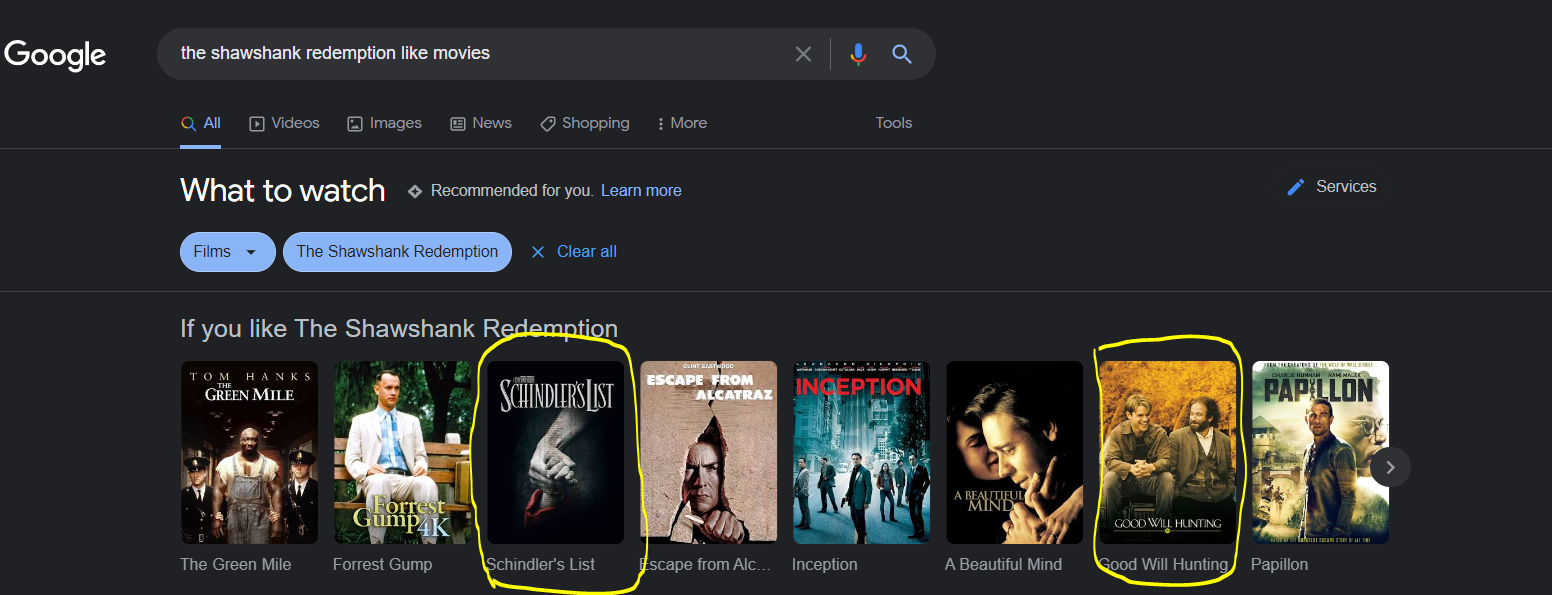

- As we can clearly see, out of the 4 movies that our simple **Pearson Correlation** based Recomm System recommended, we got two movies (highlighed) which are recommended by Google also.
- Which means, our simple system is pretty descent.

## User-based approach

Using the User-based approach to create a recommender system that uses Pearson Correlation

In [ ]:
tab_transpose = tab.T

In [ ]:
tab_transpose

UserID,1,10,100,1000,1001,1002,1003,1004,1005,1006,...,990,991,992,993,994,995,996,997,998,999
Title,,,,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Night Mother,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Til There Was You,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"'burbs, The",0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...And Justice for All,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Zed & Two Noughts, A",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zero Effect,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zero Kelvin (Kjærlighetens kjøtere),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
user_id =input("Enter a user_id : ")
user_id_recomm = tab_transpose[user_id]

Enter a user_id : 1001


In [ ]:
similar_movie_user_based = tab_transpose.corrwith(user_id_recomm)

In [ ]:
#Pearson Correlation

similar_movie_user_based.sort_values(ascending=False).to_frame().rename(columns={0:"Correlation"}).head()

,Correlation
UserID,
1001,1.000000
1407,0.361699
5825,0.334978
1173,0.326688
1203,0.326667


#### Obs -> 
- As we can clearly see, movies interests similar to user with user id == 5 are the users( 1484, 5452, 281, 3538) and thus we can recommend these users similar movies that user_id == 5 is watching.
- Although, this is a weak correlation ( 0.33)

# Building a Recommender System based on **Cosine Similarity** and **KNN**

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
item_sim = cosine_similarity(tab.T) # row based and hence for getting moview (items) entries in rows, we are transposing
item_sim

array([[1.        , 0.07235746, 0.03701053, ..., 0.        , 0.12024178,
        0.02700277],
       [0.07235746, 1.        , 0.11528952, ..., 0.        , 0.        ,
        0.07780705],
       [0.03701053, 0.11528952, 1.        , ..., 0.        , 0.04752635,
        0.0632837 ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.04564448],
       [0.12024178, 0.        , 0.04752635, ..., 0.        , 1.        ,
        0.04433508],
       [0.02700277, 0.07780705, 0.0632837 , ..., 0.04564448, 0.04433508,
        1.        ]])

Obs -> Similarity of one movie each (each list) accross all the users

## Item-Item Similarity:

In [ ]:
# Item-Item Similarity Matrix

item_sim_mat = pd.DataFrame(item_sim,index=tab.columns,columns = tab.columns)
item_sim_mat

Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin (Kjærlighetens kjøtere),Zeus and Roxanne,eXistenZ
Title,,,,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck",1.000000,0.072357,0.037011,0.079291,0.060838,0.000000,0.058619,0.189843,0.094785,0.058418,...,0.038725,0.076474,0.000000,0.044074,0.0,0.045280,0.039395,0.000000,0.120242,0.027003
'Night Mother,0.072357,1.000000,0.115290,0.115545,0.159526,0.000000,0.076798,0.137135,0.111413,0.046135,...,0.053010,0.087828,0.063758,0.135962,0.0,0.091150,0.074787,0.000000,0.000000,0.077807
'Til There Was You,0.037011,0.115290,1.000000,0.098756,0.066301,0.080250,0.127895,0.128523,0.079115,0.066598,...,0.029200,0.062893,0.000000,0.079187,0.0,0.022594,0.079261,0.000000,0.047526,0.063284
"'burbs, The",0.079291,0.115545,0.098756,1.000000,0.143620,0.000000,0.192191,0.250140,0.170719,0.197808,...,0.113386,0.207897,0.019962,0.138064,0.0,0.055704,0.161174,0.000000,0.033567,0.110525
...And Justice for All,0.060838,0.159526,0.066301,0.143620,1.000000,0.000000,0.075093,0.178928,0.205486,0.122431,...,0.089998,0.153006,0.067009,0.109029,0.0,0.086080,0.110867,0.074317,0.000000,0.111040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Zed & Two Noughts, A",0.045280,0.091150,0.022594,0.055704,0.086080,0.000000,0.012702,0.042295,0.039344,0.041324,...,0.047282,0.073996,0.070409,0.141537,0.0,1.000000,0.084020,0.124939,0.000000,0.137372
Zero Effect,0.039395,0.074787,0.079261,0.161174,0.110867,0.000000,0.175771,0.157313,0.133061,0.156505,...,0.179315,0.169677,0.021362,0.206870,0.0,0.084020,1.000000,0.059228,0.016838,0.242043
Zero Kelvin (Kjærlighetens kjøtere),0.000000,0.000000,0.000000,0.000000,0.074317,0.000000,0.000000,0.033120,0.036867,0.034797,...,0.048440,0.046892,0.000000,0.000000,0.0,0.124939,0.059228,1.000000,0.000000,0.045644


In [ ]:
user_sim = cosine_similarity(tab)
user_sim

array([[1.        , 0.25531859, 0.12396703, ..., 0.15926709, 0.11935626,
        0.12239079],
       [0.25531859, 1.        , 0.25964457, ..., 0.16569953, 0.13332665,
        0.24845029],
       [0.12396703, 0.25964457, 1.        , ..., 0.20430203, 0.11352239,
        0.30693676],
       ...,
       [0.15926709, 0.16569953, 0.20430203, ..., 1.        , 0.18657496,
        0.18563871],
       [0.11935626, 0.13332665, 0.11352239, ..., 0.18657496, 1.        ,
        0.10827118],
       [0.12239079, 0.24845029, 0.30693676, ..., 0.18563871, 0.10827118,
        1.        ]])

## User-User Similarity:

In [ ]:
# User Similarity Matrix:

user_sim_mat = pd.DataFrame(user_sim,index=tab.index,columns = tab.index)
user_sim_mat

UserID,1,10,100,1000,1001,1002,1003,1004,1005,1006,...,990,991,992,993,994,995,996,997,998,999
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.255319,0.123967,0.207800,0.139317,0.110320,0.121384,0.180073,0.103896,0.052816,...,0.079367,0.038048,0.032136,0.067631,0.070052,0.035731,0.170184,0.159267,0.119356,0.122391
10,0.255319,1.000000,0.259645,0.280479,0.158703,0.112917,0.141985,0.432171,0.194915,0.102487,...,0.154412,0.186234,0.083739,0.125894,0.118558,0.146552,0.304806,0.165700,0.133327,0.248450
100,0.123967,0.259645,1.000000,0.306067,0.075736,0.110450,0.358686,0.237292,0.172872,0.099147,...,0.098235,0.097953,0.065152,0.178664,0.271311,0.033754,0.344290,0.204302,0.113522,0.306937
1000,0.207800,0.280479,0.306067,1.000000,0.099117,0.047677,0.201722,0.355619,0.325966,0.130702,...,0.170100,0.076779,0.000000,0.200343,0.380741,0.044404,0.330748,0.172803,0.098456,0.250564
1001,0.139317,0.158703,0.075736,0.099117,1.000000,0.164854,0.053887,0.150069,0.138602,0.134710,...,0.146270,0.026891,0.097011,0.119609,0.092234,0.109700,0.222119,0.103255,0.269952,0.178399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.035731,0.146552,0.033754,0.044404,0.109700,0.072578,0.031406,0.088763,0.061450,0.032265,...,0.080559,0.252222,0.074207,0.098705,0.048650,1.000000,0.063925,0.019459,0.075830,0.052571
996,0.170184,0.304806,0.344290,0.330748,0.222119,0.224779,0.185226,0.351716,0.287965,0.164045,...,0.205186,0.086546,0.062523,0.186441,0.217672,0.063925,1.000000,0.179404,0.178834,0.418466
997,0.159267,0.165700,0.204302,0.172803,0.103255,0.068980,0.170771,0.175340,0.106303,0.049536,...,0.192642,0.030588,0.081380,0.162615,0.110656,0.019459,0.179404,1.000000,0.186575,0.185639


In [ ]:
# Creating a csr based decomposition/conversion of sparse matrix

from scipy.sparse import csr_matrix
csr_mat = csr_matrix(tab.T.values)

# KNN based Recommender System:

In [ ]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors= 5,metric = 'cosine', n_jobs=-1)
knn.fit(csr_mat)

NearestNeighbors(metric='cosine', n_jobs=-1)

In [ ]:
movie_name = 'Shawshank Redemption, The'
distances, indices = knn.kneighbors(tab[movie_name].values.reshape(1,-1),n_neighbors=6)
for i in range (0, len(distances.flatten())):
  if i == 0 :
    print("The movies close similar to",movie_name,"are \n")
  else:
    print(tab.columns[indices.flatten()[i]],"with a distance of",round(distances.flatten()[i],3))

The movies close similar to Shawshank Redemption, The are 

Silence of the Lambs, The with a distance of 0.319
Pulp Fiction with a distance of 0.341
Fargo with a distance of 0.344
Schindler's List with a distance of 0.345
Good Will Hunting with a distance of 0.368


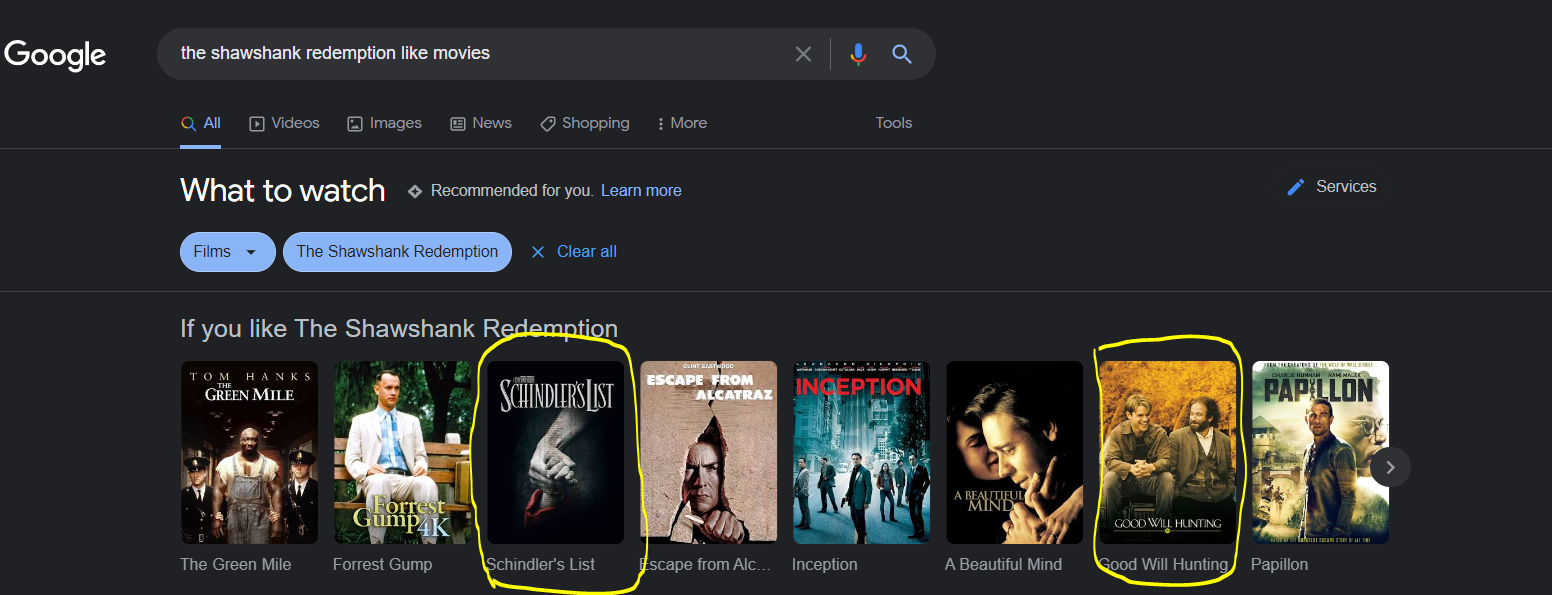

- Note, we are **getting the same two movies as we got in case of Pearson corelation** approach. 
- **No significant difference with KNN** based approach

6. Name the top 3 movies similar to ‘Liar Liar’ on the item-based approach.

In [ ]:
# 6. Name the top 3 movies similar to ‘Liar Liar’ on the item-based approach.
movie_name = 'Liar Liar'
distances, indices = knn.kneighbors(tab[movie_name].values.reshape(1,-1),n_neighbors=4)
for i in range (0, len(distances.flatten())):
  if i == 0 :
    print("The movies close similar to",movie_name,"are \n")
  else:
    print(tab.columns[indices.flatten()[i]],"with a distance of",round(distances.flatten()[i],3))

The movies close similar to Liar Liar are 

Mrs. Doubtfire with a distance of 0.443
Ace Ventura: Pet Detective with a distance of 0.483
Dumb & Dumber with a distance of 0.487


# Building a Recommender System based on **Matrix Factorization**

In [ ]:
users = df.UserID.unique()
movies = df.MovieID.unique()

In [ ]:
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

In [ ]:
df['UserID'] = df['UserID'].apply(lambda x : userid2idx[x])
df['MovieID'] = df['MovieID'].apply(lambda x : movieid2idx[x])

In [ ]:
train = df[np.random.rand(len(df)) < 0.8]
valid = df[~(np.random.rand(len(df)) < 0.8)]
print(train.shape,valid.shape)

(798843, 11) (200034, 11)


In [ ]:
n_movies = len(df['MovieID'].unique())
n_users = len(df['UserID'].unique())
n_latent_factors = 64 # Hyperparameter or hidden model factors  

In [ ]:
# Creating embedding vector for user using embedding layer from Keras

import tensorflow as tf
user_input = tf.keras.Input(shape=(1,) ,name='user_input', dtype='int64')
user_embedding = tf.keras.layers.Embedding(n_users,n_latent_factors, name='user_embedding')(user_input)
user_vec = tf.keras.layers.Flatten(name='FlattenUsers')(user_embedding)

In [ ]:
# Creating embedding vector for movie using embedding layer from Keras

movie_input = tf.keras.Input(shape=(1,) ,name='movie_input', dtype='int64')
movie_embedding = tf.keras.layers.Embedding(n_users,n_latent_factors, name='movie_embedding')(movie_input)
movie_vec = tf.keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

In [ ]:
from keras.layers.merge import dot
sim = dot([user_vec,movie_vec],name='Similarity-Dot-Product',axes=1)
model = keras.models.Model([user_input,movie_input],sim)

In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer = Adam(lr = 1e-4),loss='mse')

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 movie_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 64)        386560      ['user_input[0][0]']             
                                                                                                  
 movie_embedding (Embedding)    (None, 1, 64)        386560      ['movie_input[0][0]']            
                                                                                            

- The metrics used here is **Mean Squared Error (MSE)**
- Our objective is to **minimize this MSE** on traing data set i.e over the values which user has rated

In [ ]:
# Model Training

model_hist = model.fit([train.UserID, train.MovieID], train.Rating, batch_size = 120, epochs = 20, validation_data = ([valid.UserID, valid.MovieID], valid.Rating), verbose = 1)

Epoch 1/20
6658/6658 [==============================] - 74s 11ms/step - loss: 13.9616 - val_loss: 13.3118
Epoch 2/20
6658/6658 [==============================] - 70s 11ms/step - loss: 9.4218 - val_loss: 4.9597
Epoch 3/20
6658/6658 [==============================] - 72s 11ms/step - loss: 3.0225 - val_loss: 1.9119
Epoch 4/20
6658/6658 [==============================] - 71s 11ms/step - loss: 1.5081 - val_loss: 1.2233
Epoch 5/20
6658/6658 [==============================] - 86s 13ms/step - loss: 1.0944 - val_loss: 0.9947
Epoch 6/20
6658/6658 [==============================] - 97s 15ms/step - loss: 0.9458 - val_loss: 0.9031
Epoch 7/20
6658/6658 [==============================] - 94s 14ms/step - loss: 0.8834 - val_loss: 0.8626
Epoch 8/20
6658/6658 [==============================] - 80s 12ms/step - loss: 0.8546 - val_loss: 0.8423
Epoch 9/20
6658/6658 [==============================] - 77s 12ms/step - loss: 0.8397 - val_loss: 0.8315
Epoch 10/20
6658/6658 [==============================] - 83s 1

In [ ]:
# Model Evaluation:

y_pred = model.predict([valid.UserID, valid.MovieID], verbose  =0)
y_pred_class  =np.argmax(y_pred, axis  =1)

In [ ]:
# RMSE

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(valid.Rating, y_pred, squared = False)
print(f"RMSE : {rmse}")

RMSE : 0.8717991613115242


In [ ]:
# MAPE

from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(valid.Rating, y_pred)
print(f"MAPE : {mape}")

MAPE : 0.26917429833229933


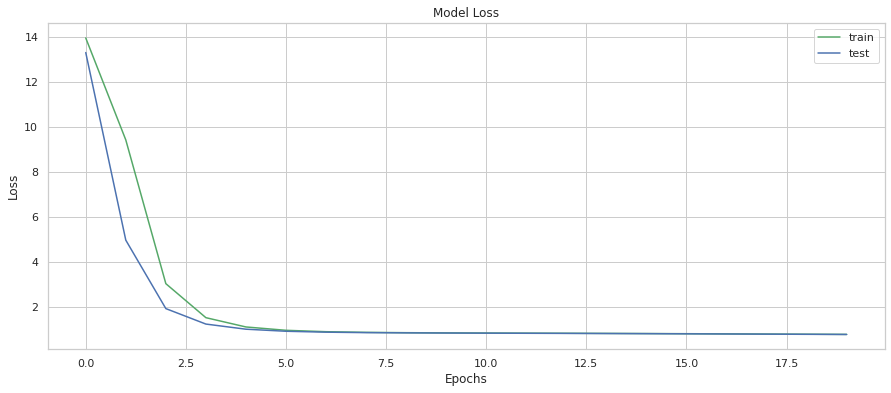

In [ ]:
# Plotting the model loss

# rcParams['figure.figsize'] = 10, 5
plt.plot(model_hist.history['loss'], 'g')
plt.plot(model_hist.history['val_loss'], 'b')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc = 'upper right')
plt.grid(True)
plt.show()


- As we can see, after 4 epochs, the loss is becoming almost constant.
- Train and test losses are coinsiding.
- The model is good.

In [ ]:
df

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,ReleaseYear
0,0,Toy Story,Animation|Children's|Comedy,0,5,2001-01-06 23:37:48,F,Under 18,K-12 student,48067,1995
1,1,Pocahontas,Animation|Children's|Musical|Romance,0,5,2001-01-06 23:39:11,F,Under 18,K-12 student,48067,1995
2,2,Apollo 13,Drama,0,5,2000-12-31 22:29:37,F,Under 18,K-12 student,48067,1995
3,3,Star Wars: Episode IV - A New Hope,Action|Adventure|Fantas,0,4,2000-12-31 22:12:40,F,Under 18,K-12 student,48067,1977
4,4,Schindler's List,Drama|War,0,5,2001-01-06 23:36:35,F,Under 18,K-12 student,48067,1993
...,...,...,...,...,...,...,...,...,...,...,...
1000204,288,Rules of Engagement,Drama|Thriller,6039,4,2000-05-16 15:12:50,M,25-34,college/grad student,92843,2000
1000205,1696,American Psycho,Comedy|Horror|Thriller,6039,2,2000-05-16 15:12:50,M,25-34,college/grad student,92843,2000
1000206,102,Keeping the Faith,Comedy|Romance,6039,5,2000-05-16 15:11:42,M,25-34,college/grad student,92843,2000
1000207,1477,U-571,Action|Thriller,6039,3,2000-05-16 15:24:59,M,25-34,college/grad student,92843,2000


1. Users of which age group have watched and rated the most number of movies?

In [ ]:
df.groupby('Age')['Rating'].count().sort_values(ascending=False).to_frame().reset_index().rename(columns={'Rating':'Count'})

,Age,Count
0,25-34,394707
1,35-44,198446
2,18-24,183172
3,45-49,83329
4,50-55,72223
5,56+,38616
6,Under 18,27147


2. Users belonging to which profession have watched and rated the most movies?

In [ ]:
df.groupby('Occupation')['Rating'].count().sort_values(ascending=False).to_frame().reset_index().rename(columns={'Rating':'Count'})

,Occupation,Count
0,college/grad student,130743
1,other,130208
2,executive/managerial,105168
3,academic/educator,85078
4,technician/engineer,72646
5,writer,60197
6,programmer,57040
7,artist,49926
8,sales/marketing,49002
9,self-employed,45898


3. Most of the users in our dataset who’ve rated the movies are Male.

In [ ]:
df.groupby('Gender')['Rating'].count().sort_values(ascending=False).to_frame().reset_index().rename(columns={'Rating':'Count'})

,Gender,Count
0,M,751679
1,F,245961


4. Most of the movies present on our dataset were released in which decade?

In [ ]:
df.groupby('ReleaseYear')['MovieID'].count().sort_values(ascending=False).to_frame().reset_index()).head(20)

,ReleaseYear,MovieID
0,1999,86833
1,1998,68165
2,1997,65402
3,1995,60754
4,1996,59271
5,1994,52963
6,1993,46245
7,2000,41000
8,1992,37866
9,1986,30865


5. The movie with maximum no. of ratings

In [ ]:
df.groupby('Title')['Rating'].sum().sort_values(ascending=False).to_frame().reset_index().rename(columns={'Rating':'Ratings_Sum'}).head(5)

,Title,Ratings_Sum
0,American Beauty,14800
1,Star Wars: Episode IV - A New Hope,13321
2,Star Wars: Episode V - The Empire Strikes Back,12836
3,Star Wars: Episode VI - Return of the Jedi,11598
4,Saving Private Ryan,11507


 6. Name the top 3 movies similar to ‘Liar Liar’ on the item-based approach.

In [ ]:
# 6. Name the top 3 movies similar to ‘Liar Liar’ on the item-based approach.
movie_name = 'Liar Liar'
distances, indices = knn.kneighbors(tab[movie_name].values.reshape(1,-1),n_neighbors=4)
for i in range (0, len(distances.flatten())):
  if i == 0 :
    print("The movies close similar to",movie_name,"are \n")
  else:
    print(tab.columns[indices.flatten()[i]],"with a distance of",round(distances.flatten()[i],3))

The movies close similar to Liar Liar are 

Mrs. Doubtfire with a distance of 0.443
Ace Ventura: Pet Detective with a distance of 0.483
Dumb & Dumber with a distance of 0.487


Questionnaire:

1. Users of which age group have watched and rated the most number of movies?
Ans -> **25-34 age group**

2. Users belonging to which profession have watched and rated the most movies?
Ans -> **college/grad student**

3. Most of the users in our dataset who’ve rated the movies are Male. (T/F)
Ans -> **True (Male are most- 751,679)**

4. Most of the movies present on our dataset were released in which decade?
- 70s **b. 90s** c. 50s d.80s
Ans -> **90s**

5. The movie with maximum no. of ratings is ___.
Ans ->**American Beauty**

6. Name the top 3 movies similar to ‘Liar Liar’ on the item-based approach.
Ans ->
- **Mrs. Doubtfire** with a distance of 0.443
- **Ace Ventura: Pet Detective** with a distance of 0.483
- **Dumb & Dumber** with a distance of 0.487 

7. On the basis of approach, Collaborative Filtering methods can be classified into **memory-based** and  **model-based.**
-> Memory based colab filtering has user-user and item-item whereas, model-based has Matrix Factorization

8. Pearson Correlation ranges between **-1 to +1** whereas, Cosine Similarity belongs to the interval between **0 to 1**

9. Mention the RMSE and MAPE that you got while evaluating the Matrix Factorization model.
Ans ->
- **RMSE -87.17%**
- **MAPE -> 27 %**


10. Give the sparse ‘row’ matrix representation for the following dense matrix -

[[1 0]
[3 7]]

Ans - CSR can be represented as 
- (0,0)1
- (0,1)0
- (1,0)3
- (1,1)7
